In [0]:
import tensorflow as tf
##tf.enable_eager_execution()
import pandas as pd
import numpy as np
from tensorflow.contrib import rnn
#from keras.layers import RNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score,roc_curve,auc
from google.colab import drive
import os
import time
import tensorflow_probability as tfp

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statistics as stat
##Change Directory if needed
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/DataSet')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **TensorFlow Implementation**

In [0]:
##Importing the Data

In [0]:
###2. Complete Data
missingvalues = [-1, -4, 'na']
adnimerge = pd.read_csv('ADNIMERGE.csv',na_values = missingvalues)
print(adnimerge.columns)
print(print(adnimerge.groupby(['DX']).size()))
adnimerge.head()

Index(['RID', 'PTID', 'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER',
       ...
       'TAU_bl', 'PTAU_bl', 'FDG_bl', 'PIB_bl', 'AV45_bl', 'Years_bl',
       'Month_bl', 'Month', 'M', 'update_stamp'],
      dtype='object', length=113)
DX
CN          3276
Dementia    2207
MCI         4361
dtype: int64
None


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,...,DIGITSCOR_bl,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.36665,NaN,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,34.0,112.0,0.0,-4.37389,-4.17931,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.08355,NaN,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,148.0,10.0,-16.61980,-16.20680,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.05803,NaN,NaN,NaN,NaN,NaN,6.0,19.00,30.00,10.0,24.0,19.0,2.0,6.0,100.0000,NaN,19.0,135.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,148.0,10.0,-16.61980,-16.20680,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6,2019-02-14 23:58:27.0
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.09690,NaN,NaN,601.4,251.7,24.18,3.5,24.00,35.00,10.0,17.0,31.0,2.0,7.0,100.0000,0.0,21.0,126.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,148.0,10.0,-16.61980,-16.20680,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.999316,11.96720,12,12,2019-02-14 23:58:27.0
4,3,011_S_0003,m24,11,ADNI1,ADNI1,2007-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.03258,NaN,NaN,NaN,NaN,NaN,8.0,25.67,37.67,10.0,19.0,23.0,1.0,5.0,100.0000,0.0,16.0,275.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,148.0,10.0,-16.61980,-16.20680,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,1.998630,23.93440,24,24,2019-02-14 23:58:27.0


#Functions

In [0]:
###Defining the LSTM Cell
def recurrent_neural_network_model():
    layer ={ 'weights': tf.Variable(tf.random_normal([n_units, n_classes])),'bias': tf.Variable(tf.random_normal([n_classes]))}

    x = tf.split(xplaceholder, n_features, 1)
    print(x)

    lstm_cell = rnn.LSTMCell(n_units,reuse = tf.AUTO_REUSE)
#    lstm_cell = rnn.LSTMCell(n_units,reuse=tf.get_variable_scope().reuse)
    
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
   
    output = tf.matmul(outputs[-1], layer['weights']) + layer['bias']

    return output

In [0]:
###Training Model
def trainmodel():
    logit = recurrent_neural_network_model()
    logit = tf.reshape(logit, [-1])
    cost_list = []
    index_list = []
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit, labels=yplaceholder))
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    with tf.Session() as sess:
        X_train,X_test,y_train,y_test = train_test_split(features, labels, test_size=0.2, shuffle=False, random_state=0)
        X_train,y_train = perform_smote(X_train,y_train)
        ##print(X_train)
        ##print(X_test)
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
         
        for epoch in range(epochs):
            epoch_loss = 0

            i = 0
            for i in range(int(len(X_train) / batch_size)):
                start = i
                end = i + batch_size

                batch_x = np.array(X_train[start:end])
                batch_y = np.array(y_train[start:end])

                _, c = sess.run([optimizer, cost], feed_dict={xplaceholder: batch_x, yplaceholder: batch_y})
                epoch_loss += c
                i += batch_size

            #print('Epoch', epoch, 'completed out of', epochs, 'loss:', epoch_loss)
            if (epoch+1) % 5 == 0: 
              cost_list.append(epoch_loss)
              index_list.append(epoch+1)
        plt.plot(index_list,cost_list)
        plt.xticks(index_list,rotation='vertical')
        plt.xlabel("Number of Iterarion")
        plt.ylabel("Loss")
        plt.show()
        pred = tf.round(tf.nn.sigmoid(logit)).eval({xplaceholder: np.array(X_test), yplaceholder: np.array(y_test)})
        predr = (tf.nn.sigmoid(logit)).eval({xplaceholder: np.array(X_test), yplaceholder: np.array(y_test)})
        fpr, tpr, thresholds = roc_curve(np.array(y_test), predr)
        f1 = f1_score(np.array(y_test), pred, average='macro')
        accuracy= accuracy_score(np.array(y_test), pred)
        recall = recall_score(y_true=np.array(y_test), y_pred= pred)
        precision = precision_score(y_true=np.array(y_test), y_pred=pred)
        print("F1 Score:", f1)
        print("Accuracy Score:",accuracy)
        #print("Recall:", recall)
        #print("Precision:", precision)
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr, tpr, color='darkorange',lw=2,label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        
        
    tf.reset_default_graph()
    #print(sess._closed)
    #sess.close()
    #print(sess._closed)
    return np.array(y_test),predr

In [0]:
def visualize_feature(features, feat_importance):
    """
        Visualize important features
    """
    feat_importance,features = zip(*sorted(zip(feat_importance,features)))
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set(xlabel='Name', ylabel='Importance',
           title='Feature Importance Level')
    ax.bar(features, feat_importance)
    plt.xticks(features, rotation='vertical')
    plt.show()

In [0]:
tf.reset_default_graph()

# **Using MRI Scan Data**

In [0]:
mri = ['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain','DX']
##mridata = adnimerge[mri][(adnimerge['VISCODE'] == 'bl') & (adnimerge['ORIGPROT'] == 'ADNI1') & (adnimerge['DX'] != 'CN')]
##Changing for all available data
#mridata = adnimerge[mri][(adnimerge['VISCODE'] == 'bl') & (adnimerge['ORIGPROT'] == 'ADNI1')]
mridata = adnimerge[mri]
##Moved below code to the next section
#mridata[mridata['DX'] == 'MCI'] = mridata[mridata['DX'] == 'MCI'].assign(DX='CN') 
#mridata['DX_Code'] = LabelEncoder().fit_transform(mridata.DX)
print(mridata.shape)
#mridata.head()

(13862, 8)


In [0]:
mridata = mridata[mridata['Hippocampus'].isna() == False]
mridata = mridata[mridata['Ventricles'].isna() == False]
mridata = mridata[mridata['Entorhinal'].isna() == False]
mridata = mridata[mridata['WholeBrain'].isna() == False]
mridata = mridata[mridata['DX'].isna() == False]
mridata[mridata['DX'] == 'MCI'] = mridata[mridata['DX'] == 'MCI'].assign(DX='CN') 
mridata['DX_Code'] = LabelEncoder().fit_transform(mridata.DX)
print(mridata.shape)
print(mridata.groupby(['DX']).size())
print(mridata.isnull().sum())

mridata.head()

(5470, 9)
DX
CN          4322
Dementia    1148
dtype: int64
Ventricles     0
Hippocampus    0
Entorhinal     0
Fusiform       0
MidTemp        0
ICV            0
WholeBrain     0
DX             0
DX_Code        0
dtype: int64


,Ventricles,Hippocampus,Entorhinal,Fusiform,MidTemp,ICV,WholeBrain,DX,DX_Code
0,118233.0,8336.0,4177.0,16559.0,27936.0,1984660.0,1229740.0,CN,0
1,84599.0,5319.0,1791.0,15506.0,18422.0,1920690.0,1129830.0,Dementia,1
2,88580.0,5446.0,2427.0,14400.0,16972.0,1906430.0,1100060.0,Dementia,1
3,90099.0,5157.0,1596.0,14617.0,17330.0,1903820.0,1095640.0,Dementia,1
4,97420.0,5139.0,1175.0,14033.0,16398.0,1903420.0,1088560.0,Dementia,1


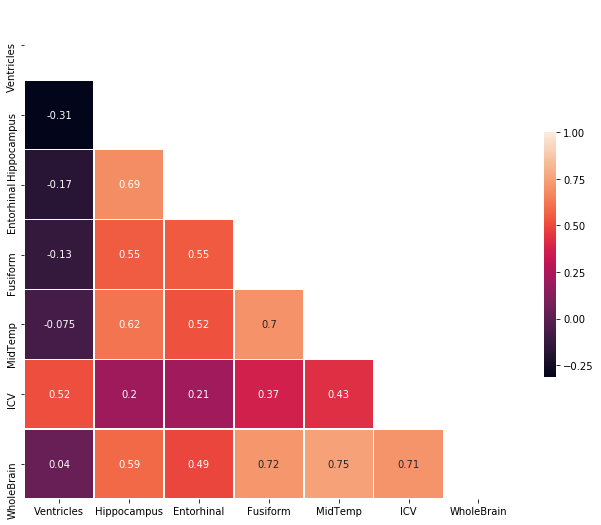

In [0]:
### Finding the Correlation between the Input at single Modal

feat = mridata[['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain']]
corr = feat.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5,  cbar_kws={"shrink": .5},annot=True)

### **Analysis with the traditional Algorithms**

In [0]:
##Performing PCA
from sklearn.datasets import load_digits
from sklearn.decomposition import KernelPCA
##X, _ = load_digits(return_X_y=True)
def perform_PCA(features):
  transformer = KernelPCA(kernel='linear')
  X_transformed = transformer.fit_transform(features)
  print(features.shape)
  print(X_transformed.shape)
  return X_transformed


In [0]:
from imblearn.over_sampling import SMOTE
def perform_smote(X_train,y_train):

  print(X_train.shape)
  smote = SMOTE(random_state = 0)
  X_train, y_train = smote.fit_sample(X_train, y_train)
  print(X_train.shape)
  return X_train,y_train



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from sklearn.preprocessing import MinMaxScaler
def perform_scale(features):

    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    return features

### Logistic Regression

(5470, 7)
(5470, 2726)
(4376, 2726)
(6656, 2726)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score: 0.7142292986032124
Accuracy Score: 0.8839122486288848


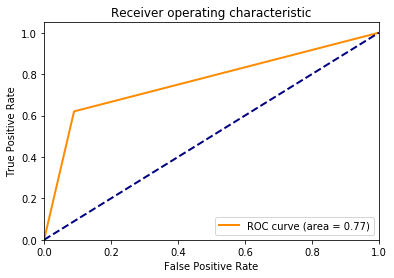

In [0]:
from sklearn.linear_model import LogisticRegression
feat = ['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain']
features = mridata[['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain']].values
labels = mridata['DX_Code'].values

features = perform_scale(features)
features = perform_PCA(features)
X_train,X_test,y_train,y_test = train_test_split(features, labels, test_size=0.2, shuffle=False, random_state=42)
X_train,y_train = perform_smote(X_train,y_train)
clf = LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

f1 = f1_score(y_test, predictions, average='macro')
print("F1 Score:", f1)
print("Accuracy Score:",accuracy)
fprlr, tprlr, thresholdslr = roc_curve(np.array(y_test), predictions)
roc_auc = auc(fprlr,tprlr)
plt.plot(fprlr, tprlr, color='darkorange',lw=2,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
##visualize_feature(feat,clf.feature_importances_)  
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title('Feature Importance')
    plt.show()
#f_importances(abs(clf.coef_[0]),feat)

### Random Forest

F1 Score: 0.7743399339933994
Accuracy Score: 0.9360146252285192


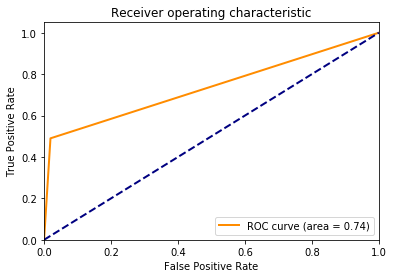

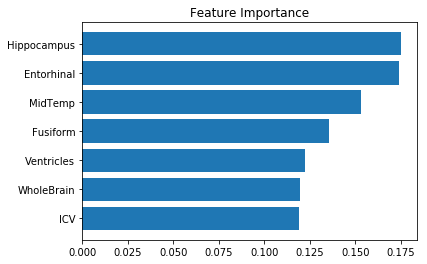

In [0]:
seed = 0
from sklearn.ensemble import RandomForestClassifier
feat = ['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain']
###After the recursive feature selection
features = mridata[['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain']]
##features = mridata[['Hippocampus','Entorhinal']]
labels = mridata['DX_Code'].values
features = perform_scale(features)
#features = perform_PCA(features)
X_train,X_test,y_train,y_test = train_test_split(features, labels, test_size=0.2, shuffle=False, random_state=42)
#X_train,y_train = perform_smote(X_train,y_train)
clf = RandomForestClassifier(n_estimators=1000,criterion="entropy",max_features=0.25, random_state=seed,class_weight='balanced')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average='macro')
print("F1 Score:", f1)
print("Accuracy Score:",accuracy)
##visualize_feature(feat,clf.feature_importances_)  
fprrf, tprrf, thresholdsrf = roc_curve(np.array(y_test), predictions)
roc_auc = auc(fprrf,tprrf)
plt.plot(fprrf, tprrf, color='darkorange',lw=2,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
f_importances(clf.feature_importances_,feat)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators=500,criterion="entropy",max_features=0.25, random_state=seed,class_weight='balanced'))
sel.fit(X_train, y_train)
##print(sel.get_support())
selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

2
Index(['Hippocampus', 'Entorhinal'], dtype='object')


In [0]:
from sklearn.feature_selection import RFE
model = RandomForestClassifier(n_estimators=500,criterion="entropy",max_features=0.25, random_state=seed,class_weight='balanced')
rfe = RFE(model, 3)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

[False  True  True False  True False False]
[4 1 1 2 1 5 3]
2
Index(['Hippocampus', 'Entorhinal'], dtype='object')


### SVM

In [0]:
##Useless takes a lot of time
from sklearn.svm import SVC
feat = ['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain']
features = mridata[['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain']].values
labels = mridata['DX_Code'].values
features = perform_PCA(features)
X_train,X_test,y_train,y_test = train_test_split(features, labels, test_size=0.2, shuffle=False, random_state=42)
X_train,y_train = perform_smote(X_train,y_train)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score:", f1)
print("Accuracy Score:",accuracy)
fprsvm, tprsvm, thresholdsvm = roc_curve(np.array(y_test), predictions)
roc_auc = auc(fprsvm,tprsvm)
plt.plot(fprsvm, tprsvm, color='darkorange',lw=2,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
f_importances(abs(clf.coef_[0]),feat)

(661, 7)
(661, 336)
(528, 336)
(828, 336)


### LSTM

In [0]:
feat = ['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain']
features = mridata[['Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','ICV','WholeBrain']].values
labels = mridata['DX_Code'].values
features = perform_scale(features)
#features = perform_PCA(features)


### Hyper Parameters for LSTM Model
epochs = 10
n_classes = 1
n_units = 5
n_features = features.shape[1]
batch_size = 200

[<tf.Tensor 'split:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:5' shape=(?, 1) dtype=float32>, <tf.Tensor 'split:6' shape=(?, 1) dtype=float32>]
(4376, 7)
(6656, 7)


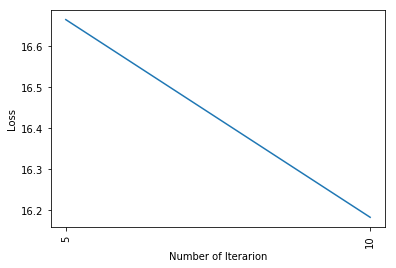

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score: 0.47605363984674326
Accuracy Score: 0.9085923217550275


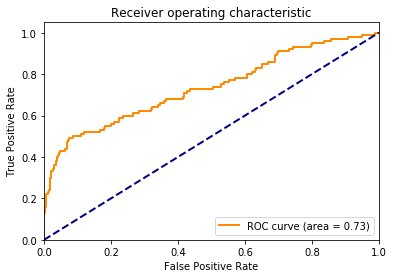

In [0]:
xplaceholder= tf.placeholder('float',[None,n_features])
yplaceholder = tf.placeholder('float')
origblcross,predblcross = trainmodel()

Keras

In [0]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(features.shape[1], embedding_vecor_length, input_length=features.shape[1]))
model.add(LSTM(100)
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=10, batch_size=10)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

TypeError: ignored

### AUC

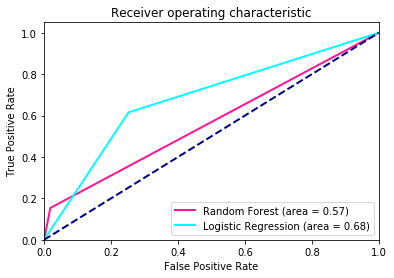

In [0]:
plt.plot(fprrf, tprrf, color='deeppink',lw=2,label='Random Forest (area = %0.2f)' % auc(fprrf,tprrf))
plt.plot(fprlr, tprlr, color='aqua',lw=2,label='Logistic Regression (area = %0.2f)' % auc(fprlr,tprlr))
#plt.plot(fprsvm, tprsvm, color='cornflowerblue',lw=2,label='SVM (area = %0.2f)' % auc(fprsvm,tprsvm))
#plt.plot(fpr, tpr, color='darkorange',lw=2,label='LSTM (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Deep Learning Feature Importance Function

This method is based on drop out feature based method https://arxiv.org/pdf/1712.08645.pdf
Here One feature will be removed in each iteration and accuracy other measures will be observed to changed and final decision will be made.

In [0]:
blcross = pd.read_csv('CrossSecDataAtBL.csv')

In [0]:
def neural_network_feature_importance():
    layer ={ 'weights': weights,'bias': bias}
    x = tf.split(xplaceholder, n_features, 1)   
    lstm_cell = rnn.LSTMCell(n_units,reuse = tf.AUTO_REUSE,activation = 'tanh',forget_bias = 0)
    outputs, states = rnn.static_rnn(lstm_cell, x,dtype=tf.float32)
    output = tf.matmul(outputs[-1], layer['weights']) + layer['bias']

    return output



In [0]:
## Performing Cross Validation
from sklearn.model_selection import RepeatedKFold 
def CrossValidateForFeatureImportance():
    #tf.reset_default_graph()
    #initializeparam()
    #initializeplaceholder()
    logit = neural_network_feature_importance()
    logit = tf.reshape(logit, [-1])
    f1_list = []
    accuracy_list = []
    recall_list = []
    precision_list = []
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit, labels=yplaceholder))
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    with tf.Session() as sess:
        X_train,X_test,y_train,y_test = train_test_split(features, labels, test_size=0.2, shuffle=False, random_state=42)
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        kf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
        for train_index, test_index in kf.split(features):
            ##print("Train:", train_index, "Validation:",test_index)
            X_train, X_test = features[train_index], features[test_index] 
            y_train, y_test = labels[train_index], labels[test_index]
            for epoch in range(epochs):
                epoch_loss = 0

                i = 0
                for i in range(int(len(X_train) / batch_size)):
                    start = i
                    end = i + batch_size

                    batch_x = np.array(X_train[start:end])
                    batch_y = np.array(y_train[start:end])

                    _, c = sess.run([optimizer, cost], feed_dict={xplaceholder: batch_x, yplaceholder: batch_y})
                    epoch_loss += c
                    i += batch_size

                ##print('Epoch', epoch, 'completed out of', epochs, 'loss:', epoch_loss)

            pred = tf.round(tf.nn.sigmoid(logit)).eval({xplaceholder: np.array(X_test), yplaceholder: np.array(y_test)})
            predr = (tf.nn.sigmoid(logit)).eval({xplaceholder: np.array(X_test), yplaceholder: np.array(y_test)})
            f1 = f1_score(np.array(y_test), pred, average='macro')
            accuracy=accuracy_score(np.array(y_test), pred)
            recall = recall_score(y_true=np.array(y_test), y_pred= pred)
            precision = precision_score(y_true=np.array(y_test), y_pred=pred)
            #print("F1 Score:", f1)
            f1_list.append(f1)
            #print("Accuracy Score:",accuracy)
            accuracy_list.append(accuracy)
            #print("Recall:", recall)
            recall_list.append(recall)
            #print("Precision:", precision)
            precision_list.append(precision)
    f1_score_temp = stat.mean(f1_list)
    #print("Average F1 Score:", f1_score_temp)
    #print("Average Accuracy Score:", stat.mean(accuracy_list))
    #print("Average Recall:", stat.mean(recall_list))
    #print("Average Precision:", stat.mean(precision_list))
    #tf.reset_default_graph()
    return f1_score_temp

In [0]:
tf.reset_default_graph()
feat = ['PTEDUCAT','AGE','PTGENDER_Code','PTETHCAT_Code','PTRACCAT_Code','PTMARRY_Code','LDELTOTAL','Ventricles','Hippocampus','MidTemp','AngularLeft','AngularRight','CingulumPostBilateral','TemporalLeft','TemporalRight']
features = blcross[['PTEDUCAT','AGE','PTGENDER_Code','PTETHCAT_Code','PTRACCAT_Code','PTMARRY_Code','LDELTOTAL','Ventricles','Hippocampus','MidTemp','AngularLeft','AngularRight','CingulumPostBilateral','TemporalLeft','TemporalRight']].values
labels = blcross['DX_Code'].values
## Constant parameters
epochs = 10 ### Should be Constant
n_classes = 1
n_units = 10
batch_size = 10
##Weight and Bias

bias = tf.Variable([0.1])

weights = tf.Variable([[ 0.83278215],
           [ 1.7731416 ],
           [ 1.7996391 ],
           [-1.1422378 ],
           [ 1.1669127 ],
           [ 0.523059  ],
           [ 0.21038328],
           [ 0.16735107],
           [-1.0397089 ],
           [-0.43292055]])

## Variable parameters
n_features = features.shape[1]

xplaceholder= tf.placeholder('float',[None,n_features])
yplaceholder = tf.placeholder('float')
superf1score = CrossValidateForFeatureImportance()
super_features = features

W0803 12:26:46.707100 140184908089216 deprecation.py:323] From <ipython-input-6-99de91df55c2>:4: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0803 12:26:46.709312 140184908089216 deprecation.py:323] From <ipython-input-6-99de91df55c2>:5: static_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
W0803 12:26:46.747533 140184908089216 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argume

In [0]:
## This algorithm takes time based on the epoch
f1 = []
for i in range(super_features.shape[1]):
    tf.reset_default_graph()
    ## Constant parameters
    epochs = 10 ### Should be Constant
    n_classes = 1
    n_units = 10
    batch_size = 10
    ##Weight and Bias

    bias = tf.Variable([0.1])

    weights = tf.Variable([[ 0.83278215],
               [ 1.7731416 ],
               [ 1.7996391 ],
               [-1.1422378 ],
               [ 1.1669127 ],
               [ 0.523059  ],
               [ 0.21038328],
               [ 0.16735107],
               [-1.0397089 ],
               [-0.43292055]])
    features = np.delete(super_features, i, axis=1)
    n_features = features.shape[1]

    xplaceholder= tf.placeholder('float',[None,n_features])
    yplaceholder = tf.placeholder('float')
    f1temp = CrossValidateForFeatureImportance()
    f1.append(f1temp)
    #print('Feature')
    #print(i)
f1df = pd.DataFrame({'Score':superf1score-f1,'Feature':feat})
print('Feature Importance is as follows')
f1df.sort_values(by = ['Score'],ascending = False)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: Undefined

Feature Importance is as follows


,Score,Feature
6,0.210079,LDELTOTAL
10,0.068637,AngularLeft
12,0.064425,CingulumPostBilateral
11,0.063654,AngularRight
5,0.061299,PTMARRY_Code
13,0.056140,TemporalLeft
7,0.052304,Ventricles
0,0.011570,PTEDUCAT
4,-0.011943,PTRACCAT_Code
14,-0.012727,TemporalRight
